# Tag 1
## Anwendungsfalls
In traditionellen Schweizer Alpkäsereien lagern Käselaibe auf Holzregalen zur Reifung. Eine automatisierte Erkennung und Zählung dieser Laibe auf Bildern – z.B. aus einer Produktionsüberwachung oder einem Kontrollsystem – kann zur Qualitätskontrolle, Bestandsaufnahme oder Prozessoptimierung beitragen. Besonders in kleinen, handwerklichen Betrieben kann so der Aufwand reduziert und die Nachverfolgbarkeit verbessert werden.

## Problemstellung
Die Käselaibe haben meist eine gleichmässige, runde Form und eine gelblich-bräunliche Färbung, die sich vom Holzregal oder dem dunkleren Reiferaumhintergrund abhebt. Je nach Lichtverhältnissen, Schatten oder teilweiser Überlappung kann die visuelle Trennung jedoch schwierig sein. Ziel ist es, diese gleichartigen Objekte automatisch zu segmentieren, ohne manuelles Zählen. Dies kann insbesondere dann herausfordernd sein, wenn Laibe eng beieinander liegen oder teilweise verdeckt sind.

## Ziel der Segmentierung
Durch die Segmentierung der Käselaibe im Bild soll eine zuverlässige Zählung, Lokalisierung und ggf. Flächenschätzung einzelner Laibe ermöglicht werden. Die daraus gewonnenen Daten können genutzt werden, um Lagerbestände zu automatisieren, Reifeverläufe über Zeiträume zu dokumentieren oder auch visuelle Auffälligkeiten (z.B. Schimmelbildung) frühzeitig zu erkennen – ein praktischer Nutzen für die Lebensmittelüberwachung und das digitale Alpkäsemanagement.

## Bild
![Kaeselaibe im Regal](../data/Kaese.jpg)

Quelle: https://www.loisirs.ch/agendas/32860/les-secrets-de-la-fabrication-de-fromage-d-alpage-a-la-poyettaz


# Tag 6

Gezählte Käselaibe: 9


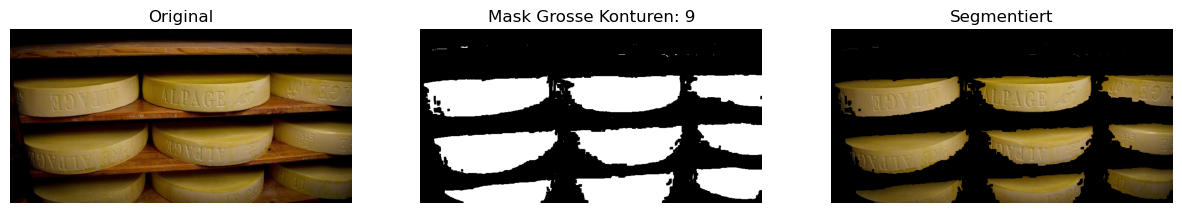

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Bild laden und vorbereiten
img = cv2.imread("C:\\Users\\silas\\PycharmProjects\\GBSV_2025\\MC2\\Data\\Kaese.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

# Farbsegmentierung (LAB)
lower = np.array([40, 110, 0])
upper = np.array([220, 133, 255])
mask = cv2.inRange(lab, lower, upper)

# Maske bereinigen
kernel = np.ones((5, 5), np.uint8)
mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Konturen finden und nach Fläche filtern
contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area = 4000
large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

# Ergebnis
num_objects = len(large_contours)
print(f"Gezählte Käselaibe: {num_objects}")

# Segmentiertes Bild erstellen
result = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_cleaned)

# Visualisierung
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1), plt.title("Original"), plt.imshow(img_rgb), plt.axis("off")
plt.subplot(1, 3, 2), plt.title(f"Mask Grosse Konturen: {num_objects}"), plt.imshow(mask_cleaned, cmap="gray"), plt.axis("off")
plt.subplot(1, 3, 3), plt.title("Segmentiert"), plt.imshow(result), plt.axis("off")
plt.show()

Gezählte Käselaibe: 9


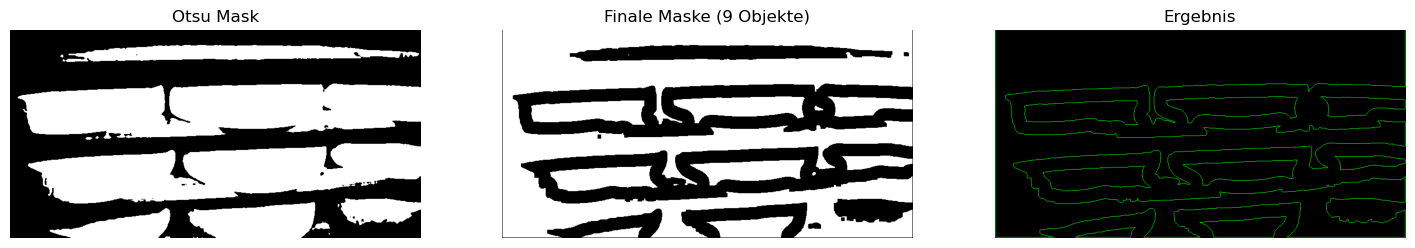

In [575]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Bild laden und vorbereiten
img = cv2.imread("C:\\Users\\silas\\PycharmProjects\\GBSV_2025\\MC2\\Data\\Kaese.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 2. Rauschreduzierung (angepasste Parameter)
blurred = cv2.medianBlur(gray, 5)  # Besser bei Salz-Pfeffer-Rauschen als GaussianBlur

# 3. Thresholding (Otsu, nicht invertiert!)
_, otsu_mask = cv2.threshold(blurred, 190, 200, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 4. Kleine Störungen entfernen (Rauschen filtern)
kernel = np.ones((3,3), np.uint8)
opened = cv2.morphologyEx(otsu_mask, cv2.MORPH_OPEN, kernel, iterations=3)  # Entfernt kleine weiße Punkte

# 5. Watershed vorbereiten
dist_transform = cv2.distanceTransform(opened, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.4 * dist_transform.max(), 255, 0)  # Marker für Laibe
sure_fg = np.uint8(sure_fg)

# 6. Watershed anwenden
unknown = cv2.subtract(opened, sure_fg)
_, markers = cv2.connectedComponents(sure_fg)
markers += 1
markers[unknown == 0] = 100
markers = cv2.watershed(img, markers)

# 7. Ergebnis extrahieren (Nur Objekte, kein Hintergrund/Rauschen)
final_mask = np.zeros_like(gray, dtype=np.uint8)
final_mask[markers > 1] = 100  # Marker >1 = Käselaibe

# 8. Konturen zählen (nur große Flächen)
contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area = 500  # Mindestfläche für einen Käselaib (anpassen!)
valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
num_objects = len(valid_contours)
print(f"Gezählte Käselaibe: {num_objects}")

# 9. Visualisierung
colored_labels = np.zeros_like(img)
for i, cnt in enumerate(valid_contours):
    cv2.drawContours(colored_labels, [cnt], 0, (0, 255, 0), 1)  # Grüne Konturen

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1), plt.title("Otsu Mask"), plt.imshow(otsu_mask, cmap="gray"), plt.axis("off")
plt.subplot(1, 3, 2), plt.title(f"Finale Maske ({num_objects} Objekte)"), plt.imshow(final_mask, cmap="gray"), plt.axis("off")
plt.subplot(1, 3, 3), plt.title("Ergebnis"), plt.imshow(colored_labels), plt.axis("off")
plt.show()

# Tag 7

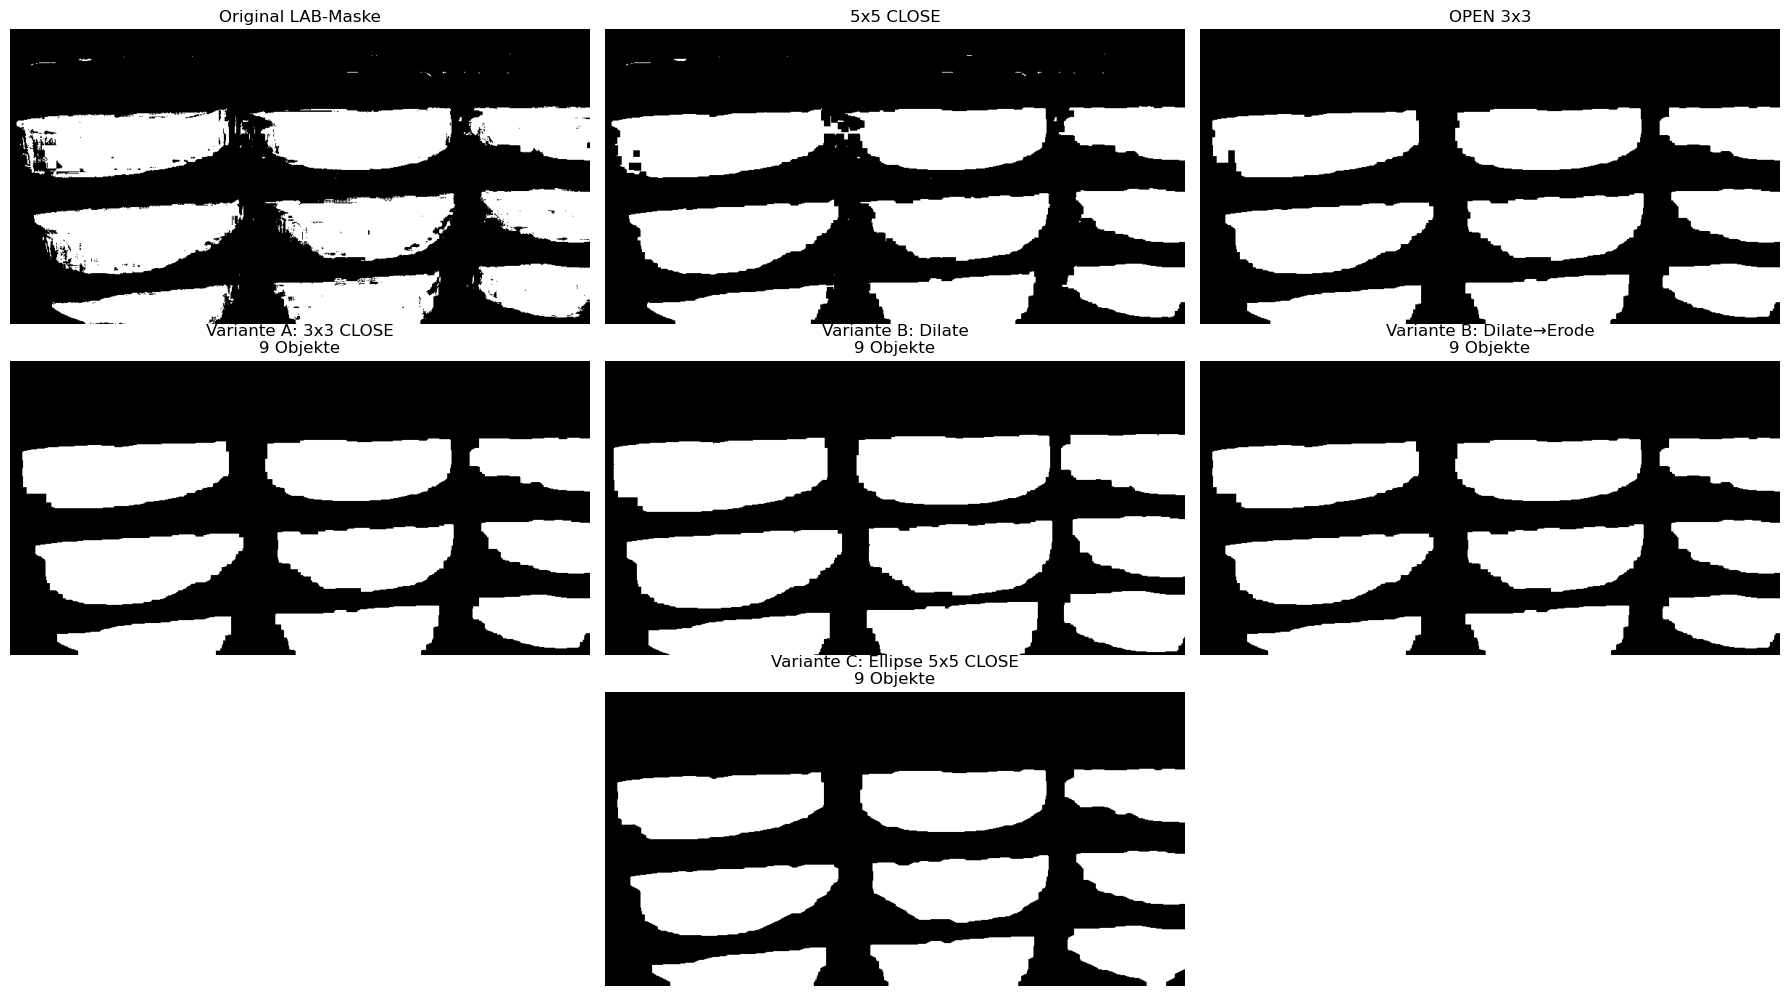

In [3]:
import cv2
# Bild laden und in verschiedene Farbräume umwandeln
img = cv2.imread("C:\\Users\\silas\\PycharmProjects\\GBSV_2025\\MC2\\Data\\Kaese.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

# LAB-Segmentierung
lower = np.array([40, 110, 0])
upper = np.array([220, 133, 255])
mask = cv2.inRange(lab, lower, upper)

# ---------------- Morphologische Operationen ----------------

# Schritt 1: Grobes Closing mit 5x5 (füllt große Lücken)
kernel_large = np.ones((5, 5), np.uint8)
mask_close5 = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_large, iterations=2)

# Schritt 2: Fein-Öffnen mit 3x3 (entfernt kleine weiße Flecken)
kernel_small = np.ones((3, 3), np.uint8)
mask_open = cv2.morphologyEx(mask_close5, cv2.MORPH_OPEN, kernel_small, iterations=5)

# Variante A: Finales Closing mit 3x3 (sanfte Lückenfüllung)
mask_refined_A = cv2.morphologyEx(mask_open, cv2.MORPH_CLOSE, kernel_small, iterations=5)

# Variante B: Alternativ mit Dilate → Erode
mask_dilated = cv2.dilate(mask_open, kernel_small, iterations=5)
mask_refined_B = cv2.erode(mask_dilated, kernel_small, iterations=5)

# Variante C: Elliptischer Kernel für rundere Lücken
kernel_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask_refined_C = cv2.morphologyEx(mask_open, cv2.MORPH_CLOSE, kernel_ellipse, iterations=5)

# ---------------- Konturen zählen ----------------

def count_objects(mask, min_area=4000):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    large = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    return len(large)

nA = count_objects(mask_refined_A)
nB = count_objects(mask_refined_B)
nC = count_objects(mask_refined_C)

# ---------------- Visualisierung ----------------

plt.figure(figsize=(18, 10))
plt.subplot(3, 3, 1), plt.title("Original LAB-Maske"), plt.imshow(mask, cmap="gray"), plt.axis("off")
plt.subplot(3, 3, 2), plt.title("5x5 CLOSE"), plt.imshow(mask_close5, cmap="gray"), plt.axis("off")
plt.subplot(3, 3, 3), plt.title("OPEN 3x3"), plt.imshow(mask_open, cmap="gray"), plt.axis("off")
plt.subplot(3, 3, 4), plt.title(f"Variante A: 3x3 CLOSE\n{nA} Objekte"), plt.imshow(mask_refined_A, cmap="gray"), plt.axis("off")
plt.subplot(3, 3, 5), plt.title(f"Variante B: Dilate\n{nB} Objekte"), plt.imshow(mask_dilated, cmap="gray"), plt.axis("off")
plt.subplot(3, 3, 6), plt.title(f"Variante B: Dilate→Erode\n{nB} Objekte"), plt.imshow(mask_refined_B, cmap="gray"), plt.axis("off")
plt.subplot(3, 3, 8), plt.title(f"Variante C: Ellipse 5x5 CLOSE\n{nC} Objekte"), plt.imshow(mask_refined_C, cmap="gray"), plt.axis("off")
plt.tight_layout()
plt.show()

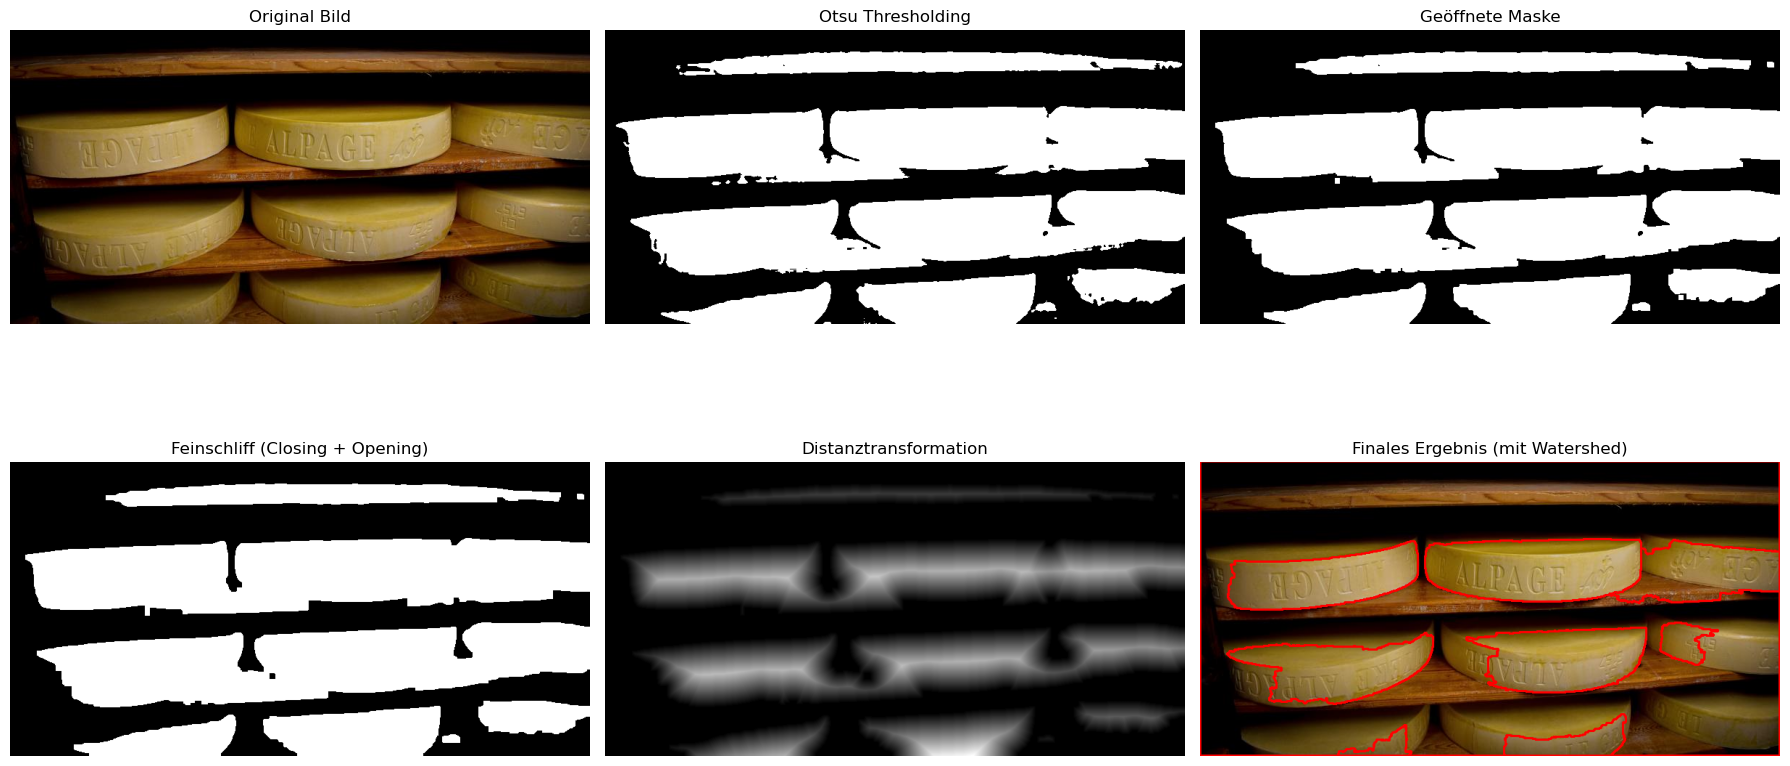

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Bild laden und Kopie erstellen
img = cv2.imread("C:\\Users\\silas\\PycharmProjects\\GBSV_2025\\MC2\\Data\\kaese.jpg")
img_original = img.copy()  # Original unverändert speichern
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Bildverarbeitungsschritte
blurred = cv2.medianBlur(gray, 5)
_, otsu_mask = cv2.threshold(blurred, 160, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel_large = np.ones((3, 3), np.uint8)
opened = cv2.morphologyEx(otsu_mask, cv2.MORPH_OPEN, kernel_large, iterations=3)
refined = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_large, iterations=3)
refined = cv2.morphologyEx(refined, cv2.MORPH_OPEN, kernel_large, iterations=3)

dist_transform = cv2.distanceTransform(refined, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.6 * dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(refined, sure_fg)

# Marker erstellen
_, markers = cv2.connectedComponents(sure_fg)
markers += 1
markers[unknown == 255] = 0  # Korrigierte Hintergrundmarkierung

# Watershed auf Kopie anwenden
img_result = img_original.copy()  # Auf unverändertem Original arbeiten
markers = cv2.watershed(img_result, markers)

# Grenzen verdicken und einzeichnen
boundary_mask = (markers == -1).astype(np.uint8)
kernel_dilate = np.ones((3, 3), np.uint8)
thick_boundaries = cv2.dilate(boundary_mask, kernel_dilate, iterations=1)
img_result[thick_boundaries == 1] = [0, 0, 255]  # Rote Grenzen

# ---------------- Visualisierung ----------------
plt.figure(figsize=(18, 10))

# Originalbild unverändert anzeigen
plt.subplot(2, 3, 1), plt.title("Original Bild"), 
plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)), plt.axis("off")

# Zwischenschritte
plt.subplot(2, 3, 2), plt.title("Otsu Thresholding"), plt.imshow(otsu_mask, cmap="gray"), plt.axis("off")
plt.subplot(2, 3, 3), plt.title("Geöffnete Maske"), plt.imshow(opened, cmap="gray"), plt.axis("off")
plt.subplot(2, 3, 4), plt.title("Feinschliff (Closing + Opening)"), plt.imshow(refined, cmap="gray"), plt.axis("off")
plt.subplot(2, 3, 5), plt.title("Distanztransformation"), plt.imshow(dist_transform, cmap="gray"), plt.axis("off")

# Finales Ergebnis mit Originalfarben + roten Grenzen
plt.subplot(2, 3, 6), plt.title("Finales Ergebnis (mit Watershed)"), 
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB)), plt.axis("off")

plt.tight_layout()
plt.show()

# Tag 8

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Maske von Tag 7 laden (Variante A als beste)
mask = mask_refined_A.copy()

# Konturen extrahieren
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Merkmale extrahieren
areas = []
perimeters = []
orientations = []

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 4000:  # Filter beibehalten
        continue

    perimeter = cv2.arcLength(cnt, True)
    M = cv2.moments(cnt)
    
    # Orientierung berechnen (in Grad)
    if M["m00"] != 0:
        orientation = 0.5 * np.arctan2(2*M["mu11"], (M["mu20"] - M["mu02"])) * (180 / np.pi)
    else:
        orientation = 0

    areas.append(area)
    perimeters.append(perimeter)
    orientations.append(orientation)

# Anzahl
print(f"Anzahl Käselaibe: {len(areas)}")

Anzahl Käselaibe: 9


Fläche: Mittel=13928.4, Std=4856.3
Umfang: Mittel=575.8, Std=107.7
Orientierung: Mittel=0.2°, Std=4.9°


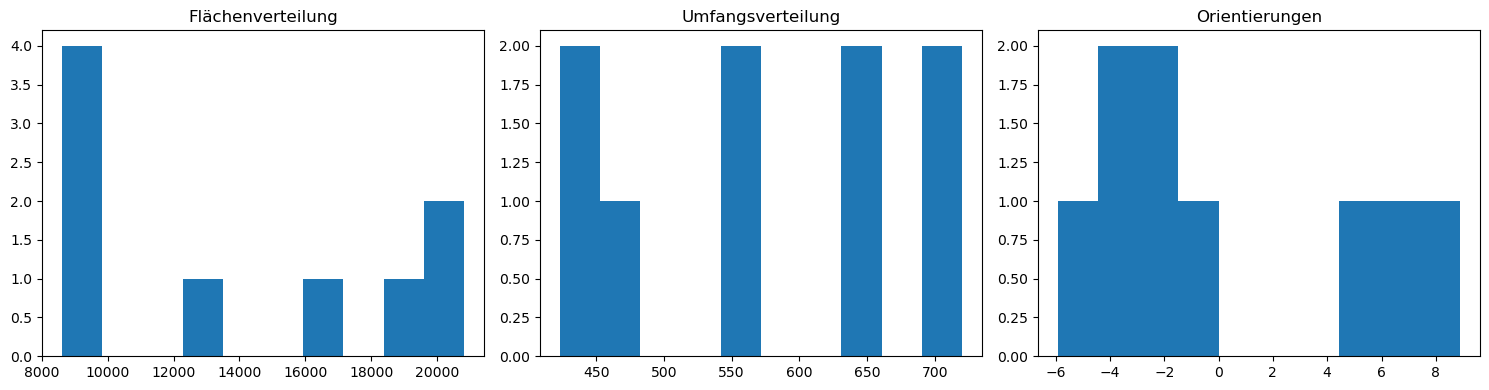

In [6]:
# Statistische Auswertung
print(f"Fläche: Mittel={np.mean(areas):.1f}, Std={np.std(areas):.1f}")
print(f"Umfang: Mittel={np.mean(perimeters):.1f}, Std={np.std(perimeters):.1f}")
print(f"Orientierung: Mittel={np.mean(orientations):.1f}°, Std={np.std(orientations):.1f}°")

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1), plt.hist(areas, bins=10), plt.title("Flächenverteilung")
plt.subplot(1, 3, 2), plt.hist(perimeters, bins=10), plt.title("Umfangsverteilung")
plt.subplot(1, 3, 3), plt.hist(orientations, bins=10), plt.title("Orientierungen")
plt.tight_layout()
plt.show()


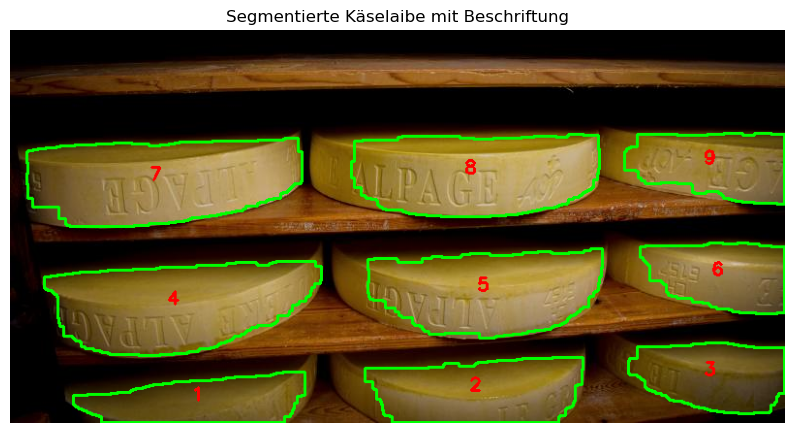

In [7]:
output = img_rgb.copy()

for i, cnt in enumerate(contours):
    area = cv2.contourArea(cnt)
    if area < 4000:
        continue

    M = cv2.moments(cnt)
    if M["m00"] == 0:
        continue
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

    cv2.drawContours(output, [cnt], -1, (0, 255, 0), 2)
    cv2.putText(output, f"{i+1}", (cx - 10, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

plt.figure(figsize=(10, 8))
plt.title("Segmentierte Käselaibe mit Beschriftung")
plt.imshow(output)
plt.axis("off")
plt.show()


# Tag 9
Noch überarbeiten

Anzahl der Skelett-Pixel: 2384


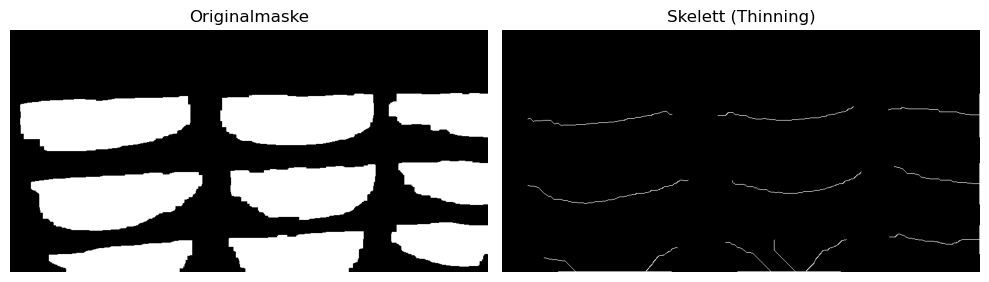

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Schritt 1: Maske laden oder verwenden
mask = mask_refined_A.copy()  # Deine vorbereitete Objektmaske (z. B. aus Segmentierung)

# Schritt 2: Binärmaske erzeugen
binary_mask = (mask > 0).astype(np.uint8) * 255  # Umwandlung in uint8 für OpenCV

# Schritt 3: Skeletonisierung per Thinning (OpenCV-Erweiterung)
# Prüfen, ob ximgproc verfügbar ist
try:
    from cv2.ximgproc import thinning
except ImportError:
    raise ImportError("Modul 'cv2.ximgproc' ist nicht installiert. Installiere OpenCV mit Extra-Modulen: pip install opencv-contrib-python")

skeleton = thinning(binary_mask)

# Schritt 4: Pixel zählen
num_skeleton_pixels = cv2.countNonZero(skeleton)
print(f"Anzahl der Skelett-Pixel: {num_skeleton_pixels}")

# Schritt 5: Visualisierung
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Originalmaske")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Skelett (Thinning)")
plt.imshow(skeleton, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()